In [1]:
import numpy as np
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

# Pytorch
import torch
import torch.nn as nn
import torch.optim as optim  
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
# from torch.utils.data.sampler import SubsetRandomSampler

from skimage.metrics import structural_similarity as ssim
from os import listdir
from tqdm import tqdm
from pathlib import Path

# Additional modules
# from dataset_creator import generate_unshuffled_csv
from assistive_funcs import filtering_image, check_ssim, check_gmsd
# from csv_dataloader import get_train_test_small_data
from image_processing import add_noise
from time import time



d:\Projects\PythonProjects\_venvs\3.9_venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# IMAGES_DIR = Path("train/")
# TEST_IMAGES_DIR = Path("test/")
# DEVICE = torch.device("cuda")


# Paths
p_main_data = Path("../data")
p_models = Path("../models")

# p_scv_folder = p_main_data / "csv_files"

p_train_images = p_main_data / "train"
p_train_gscaled_images = p_main_data / "train_gscaled"
p_train_noised_images = p_main_data / "train_noised"
p_train_filtered_images = p_main_data / "train_filtered"

p_test_images = p_main_data / "test"
p_test_gscaled_images = p_main_data / "test_gscaled"
p_test_noised_images = p_main_data / "test_noised"
p_test_filtered_images = p_main_data / "test_filtered"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

In [17]:
def save_gscaled_noised(p_imgs: Path, p_out_gscaled: Path, p_out_noised: Path) -> None:
    img_names = listdir(p_imgs)
    for name in img_names:
        gscaled_img = ImageOps.grayscale(Image.open(p_imgs / name))
        noised_img = Image.fromarray(add_noise(np.array(gscaled_img)).astype(np.uint8))
        
        gscaled_img.save(p_out_gscaled / name)
        noised_img.save(p_out_noised / name)

In [18]:
save_gscaled_noised(p_test_images, p_test_gscaled_images, p_test_noised_images)
save_gscaled_noised(p_train_images, p_train_gscaled_images, p_train_noised_images)

In [36]:
trans = transforms.CenterCrop((702, 702))
img = torch.Tensor(np.array(Image.open(p_test_gscaled_images / listdir(p_test_gscaled_images)[0])))
img

tensor([[113., 120., 127.,  ...,   0.,   0.,   0.],
        [116., 122., 127.,  ...,   0.,   0.,   0.],
        [117., 121., 126.,  ...,   0.,   0.,   0.],
        ...,
        [ 65.,  64.,  64.,  ...,   0.,   0.,   0.],
        [ 70.,  71.,  73.,  ...,   0.,   0.,   0.],
        [ 68.,  76.,  85.,  ...,   0.,   0.,   0.]])

In [37]:
img = trans(img)

In [38]:
img

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

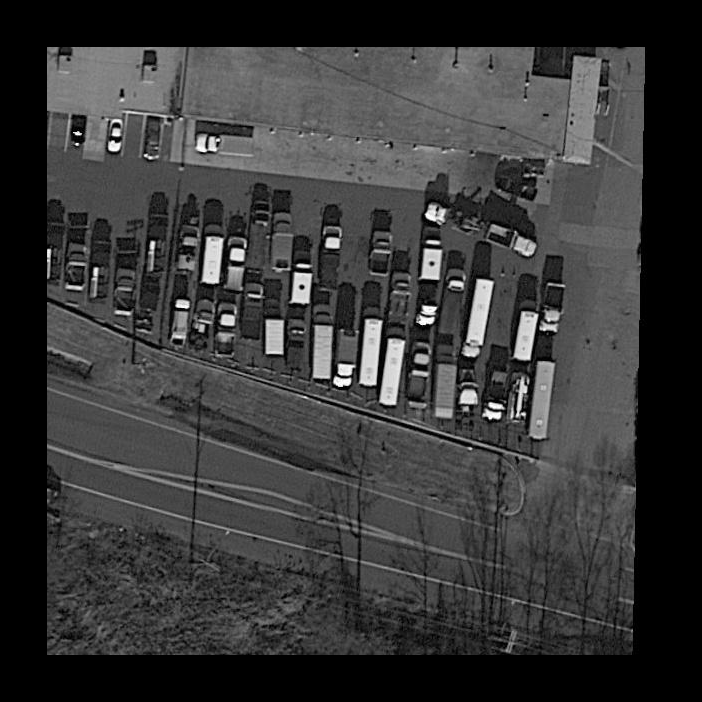

In [39]:
img = Image.fromarray(np.array(img, dtype=np.uint8))
img

In [32]:
img.size

(608, 608)

In [8]:
RESCALE_SIZE = 608

class ImageDataset(Dataset):
    def __init__(self, image_dir, normalize):
        self.image_dir = image_dir
        self.images_list = listdir(self.image_dir)

        if normalize:
            factor = 255
        else:
            factor = 1
        self.x_transform = transforms.Compose([
            transforms.Grayscale(1),
            transforms.Resize((RESCALE_SIZE, RESCALE_SIZE)),
            transforms.Lambda(add_noise),
            # transforms.Normalize(0.5, 0.5),
            transforms.Lambda(lambda x: x / factor),
            transforms.ToTensor(),
        ])
        self.y_transform = transforms.Compose([
            transforms.Grayscale(1),
            transforms.Resize((RESCALE_SIZE, RESCALE_SIZE)),
            transforms.Lambda(lambda x: x / factor),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.images_list)
    
    def __getitem__(self, index):
        image = Image.open(self.image_dir / self.images_list[index])
        noised_image = self.x_transform(image).float()
        image = self.y_transform(image)

        return noised_image, image

In [106]:
class CNNModel_(nn.Module):
    def __init__(self, num_filter=4):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=4)
            )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=4, out_channels=4, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=4)
            )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=8)
            )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=16)
            )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=32)
            )
        self.conv6 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=64)
            )
        self.conv7 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=1, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=1)
            )
    
    def forward(self, x):
        out1 = self.conv1(x)

        out2 = self.conv2(out1)
        out2 = torch.cat((out1, out2), dim=1)

        out3 = self.conv3(out2)
        out3 = torch.cat((out2, out3), dim=1)

        out4 = self.conv4(out3)
        out4 = torch.cat((out3, out4), dim=1)

        out5 = self.conv5(out4)
        out5 = torch.cat((out4, out5), dim=1)

        out6 = self.conv6(out5)
        out6 = torch.cat((out5, out6), dim=1)

        out7 = self.conv7(out6)
        return out7


In [ ]:
class FitModel():
    def __init__(self, model, criterion, optimizer, scheduler,
                 p_scv_folder, train_dataset_name,
                 batch_size, device, num_epoches, normalize_data):
        # Model
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        
        # Params
        self.num_epoches = num_epoches
        self.batch_size = batch_size
        self.device = device  
        
        # Folders
        self.p_scv_folder = p_scv_folder
        self.train_dataset_name = train_dataset_name
        
        # Flags
        self.normalize_data = normalize_data
        
        # Constants
        self.train_losses = []
        self.valid_losses = []
        self.images_filtered = False

    def _train(self, current_epoch):
        total_loss = []
        start_time = time()
        self.model.train()
        for data, targets in self.train_loader:
            
            data = data.to(device=self.device)
            targets = targets.to(device=self.device)
            if self.normalize_data:
                data /= 255
                targets /= 255
            
            scores = self.model(data)
            loss = self.criterion(scores, targets)
            loss.backward()
           
            self.optimizer.step()
            self.optimizer.zero_grad()
            
            total_loss.append(loss.item())
        
        mean_total_loss = np.mean(total_loss)
        self.train_losses.append(mean_total_loss)
        print(f"Epoch: {current_epoch}/{self.num_epoches}, time: {int(time() - start_time)}s, lr = {self.scheduler.get_last_lr()}\n\tTrain loss: {mean_total_loss:.2f}")
        
    def _valid(self, current_epoch):
        total_loss = []

        self.model.eval()
        with torch.no_grad():
            for data, targets in self.valid_loader:
                
                data = data.to(device=self.device)
                targets = targets.to(device=self.device)
                if self.normalize_data:
                    data /= 255
                    targets /= 255
                # Forward
                scores = self.model(data)
                loss = self.criterion(scores, targets)
                total_loss.append(loss.item())
        
        mean_total_loss = np.mean(total_loss)
        self.valid_losses.append(mean_total_loss)
        print(f"\tValid loss: {mean_total_loss:.2f}")
    
    def fit(self):
        self.train_loader, self.valid_loader = get_train_test_small_data(scv_folder=self.p_scv_folder, dataset_name=self.train_dataset_name,
                                                        batch_size=self.batch_size, split=True)
        for epoch in range(self.num_epoches):
            self._train(epoch + 1)
            self._valid(epoch + 1)
            if self.scheduler is not None:
                self.scheduler.step()
                
    def plot_graph(self):
        sns.set()
        fig, (ax_train, ax_test) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
        fig.suptitle('Loss')

        ax_train.set_title("Train loss")
        ax_test.set_title("Valid loss")

        ax_train.set_ylabel('Loss value')
        ax_test.set_ylabel('Loss value')

        ax_train.set_xlabel("Batch")
        ax_test.set_xlabel("Batch")

        sns.lineplot(data=self.train_losses, ax=ax_train)
        sns.lineplot(data=self.valid_losses, ax=ax_test)

        plt.show()
    
    def filtering_all_images(self):
        self.images_filtered = True
        images_names = listdir(p_test_noised_images)
        for name in images_names:
            filtering_image(self.model, p_test_filtered_images, p_test_noised_images, name, win_size, self.device, normalize_data=self.normalize_data)
        
    @staticmethod
    def _check_filtering(p_target_images, p_original_images):
        ssim_metric = []
        gmsd_metric = []
        images_names = listdir(p_target_images)
        for name in images_names:
            ssim_metric.append(check_ssim(p_target_images, p_original_images, name))
            gmsd_metric.append(check_gmsd(p_target_images, p_original_images, name))
        return ssim_metric, gmsd_metric
        # print(f"SSIM avg: {sum(ssim_metric) / len(ssim_metric)}")
        # print(f"GMSD avg: {sum(gmsd_metric) / len(gmsd_metric)}")
    
    def check_metrics(self):
        if not self.images_filtered:
            print("Warning: images weren't filtered")
        metrics_after_filtering = self._check_filtering(p_test_filtered_images, p_test_images)
        metrics_befor_filtering = self._check_filtering(p_test_noised_images, p_test_images)
        print(f"After filtering\n\tSSIM: {np.mean(metrics_after_filtering[0]):.3f}\n\tGMSD: {np.mean(metrics_after_filtering[1]):.3f}")
        
        print(f"Before filtering\n\tSSIM: {np.mean(metrics_befor_filtering[0]):.3f}\n\tGMSD: {np.mean(metrics_befor_filtering[1]):.3f}")
        


In [ ]:
learning_rate = 0.005
EPOCHES = 40
BATCH_SIZE = 2
NUM_FILTERS = 3
NORMALIZE = True

image_dataset = ImageDataset(IMAGES_DIR)
image_loader = DataLoader(image_dataset, batch_size=BATCH_SIZE, shuffle=True)
model = CNNModel_(num_filter=NUM_FILTERS).to(device=DEVICE)